In [12]:
import cupy as cp
from cupyx.scipy.ndimage import affine_transform, gaussian_filter
from cupyx.scipy.fft import fftn, ifftn
import h5py
import matplotlib.pyplot as plt
import os

In [13]:
import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display

In [14]:
# === Load and bin volumes ===
def load_volume(path):
    with h5py.File(path, 'r') as f:
        vol = f['exchange/data'][()].astype(cp.float32)
    return cp.array(vol)

def bin_volume(volume, bin_factor=2):
    z, y, x = volume.shape
    zb, yb, xb = z // bin_factor, y // bin_factor, x // bin_factor
    trimmed = volume[:zb * bin_factor, :yb * bin_factor, :xb * bin_factor]
    reshaped = trimmed.reshape(zb, bin_factor, yb, bin_factor, xb, bin_factor)
    return reshaped.mean(axis=(1, 3, 5))

def apply_translation(volume, shift, dtype=cp.float16):
    matrix = cp.eye(3, dtype=cp.float32)
    offset = cp.array(shift, dtype=cp.float32)
    volume = volume.astype(dtype)
    transformed = affine_transform(volume, matrix, offset=offset, order=1, mode='nearest')
    return transformed.astype(cp.float32)

def threshold_mask(volume, threshold=0.05):
    return (volume > threshold * cp.max(volume)).astype(cp.float32)

def percentile_mask(volume, percentile=95):
    threshold = cp.percentile(volume, percentile)
    return (volume >= threshold).astype(cp.float32)

def adaptive_mask(volume, method='percentile', fallback_threshold=0.05, percentile=95):
    if method == 'percentile':
        mask = percentile_mask(volume, percentile=percentile)
        if cp.sum(mask) < 0.01 * volume.size:
            print(f"Using fallback threshold: {fallback_threshold}")
            mask = threshold_mask(volume, fallback_threshold)
    else:
        mask = threshold_mask(volume, fallback_threshold)
    return mask

def smooth_mask(mask, sigma=1.0):
    return (gaussian_filter(mask.astype(cp.float32), sigma=sigma) > 0.5).astype(cp.float32)

# === FFT-based phase correlation ===
def parabolic_peak_3d(corr, peak):
    z, y, x = peak
    def interp(c, idx):
        a = c[idx - 1]
        b = c[idx]
        c_ = c[idx + 1]
        shift = 0.5 * (a - c_) / (a - 2 * b + c_ + 1e-8)
        return shift
    dz = interp(corr[:, y, x], z)
    dy = interp(corr[z, :, x], y)
    dx = interp(corr[z, y, :], x)
    return cp.array([z + dz, y + dy, x + dx])

def estimate_fft_shift(fixed, moving):
    shape = cp.array(fixed.shape)
    F1 = fftn(fixed)
    F2 = fftn(moving)
    cps = F1 * cp.conj(F2)
    cps /= cp.abs(cps) + 1e-8
    corr = ifftn(cps).real

    peak = cp.unravel_index(cp.argmax(corr), shape)
    peak = cp.array(peak)

    if all(1 <= peak[i] < shape[i] - 1 for i in range(3)):
        subpix_peak = parabolic_peak_3d(corr, peak)
    else:
        subpix_peak = peak.astype(cp.float32)

    shift = cp.where(subpix_peak > shape // 2, subpix_peak - shape, subpix_peak)
    return -shift

# === Visualization ===
def save_slices(outdir, idx, mode, fixed_cp, moving_cp, registered_cp, fixed_mask=None, moving_mask=None):
    os.makedirs(outdir, exist_ok=True)
    z = fixed_cp.shape[0] // 2
    f = cp.asnumpy(fixed_cp[z])
    m = cp.asnumpy(moving_cp[z])
    r = cp.asnumpy(registered_cp[z])

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs[0, 0].imshow(f, cmap='gray')
    axs[0, 0].set_title("Fixed")
    axs[0, 1].imshow(m, cmap='gray')
    axs[0, 1].set_title("Moving")
    axs[0, 2].imshow(r, cmap='gray')
    axs[0, 2].set_title("Registered")

    if fixed_mask is not None and moving_mask is not None:
        fm = cp.asnumpy(fixed_mask[z])
        mm = cp.asnumpy(moving_mask[z])
        axs[1, 0].imshow(fm, cmap='gray')
        axs[1, 0].set_title("Fixed Mask")
        axs[1, 1].imshow(mm, cmap='gray')
        axs[1, 1].set_title("Moving Mask")
        axs[1, 2].imshow(abs(f - r), cmap='magma')
        axs[1, 2].set_title("Diff: Fixed - Registered")
        fig.colorbar(axs[1, 2].images[0], ax=axs[1, 2])

    for ax in axs.ravel():
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"reg_{mode}_{idx:04d}.png"))
    plt.close()

In [15]:
cp._default_memory_pool.free_all_blocks()

base_path = "/data/2023-03-Xu_rec/NNO2_"
indices = range(1457, 1477)
out_dir = "reg_results"
shifts_fixed = []
shifts_prev = []

# Load fixed reference for mode 1
fixed_ref = bin_volume(load_volume(base_path + f"{indices[0]}_rec.h5"), bin_factor=2)

for mode in ["fixed", "rolling"]:
    ref = fixed_ref
    for i in indices:
        path = base_path + f"{i}_rec.h5"
        moving = bin_volume(load_volume(path), bin_factor=2)

        # Preprocess
        fixed_denoised = gaussian_filter(ref, sigma=1.5)
        moving_denoised = gaussian_filter(moving, sigma=1.5)
        fixed_mask = smooth_mask(adaptive_mask(fixed_denoised, percentile=95), sigma=1.0)
        moving_mask = smooth_mask(adaptive_mask(moving_denoised, percentile=95), sigma=1.0)

        fixed_masked = ref * fixed_mask
        moving_masked = moving * moving_mask

        shift = estimate_fft_shift(fixed_masked, moving_masked)
        print(f"[{mode}] {i}: shift =", shift)

        registered = apply_translation(moving, shift)
        save_slices(out_dir, i, mode, ref, moving, registered, fixed_mask, moving_mask)

        (shifts_fixed if mode == "fixed" else shifts_prev).append((i, shift.tolist()))
        if mode == "rolling":
            ref = registered

# Save displacements
import json
with open(os.path.join(out_dir, "shifts_fixed.json"), "w") as f:
    json.dump(shifts_fixed, f, indent=2)
with open(os.path.join(out_dir, "shifts_rolling.json"), "w") as f:
    json.dump(shifts_prev, f, indent=2)

[fixed] 1457: shift = [-0. -0. -0.]
[fixed] 1458: shift = [-0. -0.  1.]
[fixed] 1459: shift = [ 1. -1. -0.]
[fixed] 1460: shift = [ 1. -1. -1.]
[fixed] 1461: shift = [ 1. -2. -2.]
[fixed] 1462: shift = [ 1.69824067 -2.40797991 -2.92650237]
[fixed] 1463: shift = [ 1.67374897 -2.76485504 -2.14134568]
[fixed] 1464: shift = [ 1.77674811 -2.78851928 -1.28955731]
[fixed] 1465: shift = [ 2.54254028 -1.91645376 -3.07133781]
[fixed] 1466: shift = [ 2.92784075 -2.0579236  -2.21750742]
[fixed] 1467: shift = [ 3.84582675 -2.19616112 -1.8437912 ]
[fixed] 1468: shift = [ 4.29589912 -2.1507524  -1.26514196]
[fixed] 1469: shift = [ 4.95351755 -2.16184655 -1.82128572]
[fixed] 1470: shift = [ 5.18513976 -1.93796404 -1.16882046]
[fixed] 1471: shift = [ 5.9959329  -1.12086017 -2.14687203]
[fixed] 1472: shift = [ 6.08461582 -3.8788537  -3.96915641]
[fixed] 1473: shift = [ 5. -6.  1.]
[fixed] 1474: shift = [ 5. -6. -0.]
[fixed] 1475: shift = [ 8.73721555 -3.91090596 -3.88651283]
[fixed] 1476: shift = [ 7. -

In [16]:
def viewer(image_dir, mode, indices):
    slider = widgets.IntSlider(min=0, max=len(indices)-1, step=1, description='Slice Index')
    output = widgets.Output()

    def show_image(idx):
        index = indices[idx]
        img_path = os.path.join(image_dir, f"reg_{mode}_{index:04d}.png")
        if not os.path.exists(img_path):
            with output:
                output.clear_output(wait=True)
                print(f"Image not found: {img_path}")
            return

        img = mpimg.imread(img_path)

        with output:
            output.clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Mode: {mode} | Slice Index: {index}")
            plt.show()

    interact = widgets.interact(show_image, idx=slider)
    display(output)

In [17]:
viewer("reg_results", "fixed", list(range(1457, 1477)))

interactive(children=(IntSlider(value=0, description='Slice Index', max=19), Output()), _dom_classes=('widget-…

Output()

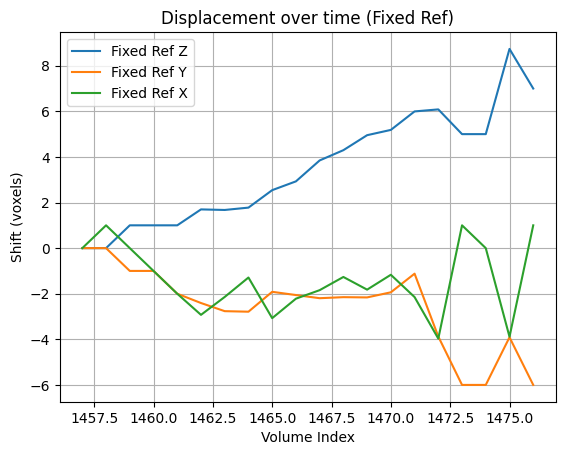

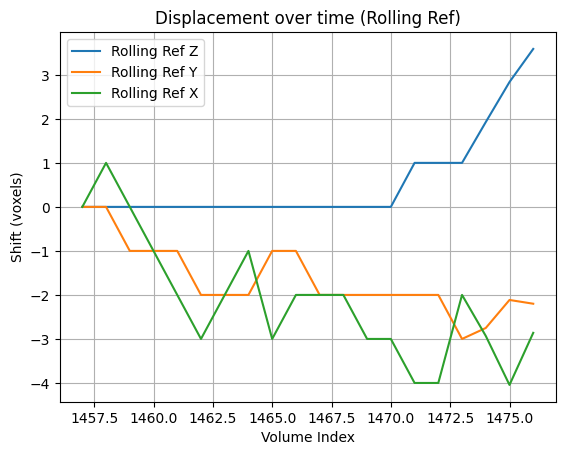

In [18]:
import matplotlib.pyplot as plt
import json
import numpy as np

def plot_shifts(path, label):
    with open(path) as f:
        data = json.load(f)
    indices = [x[0] for x in data]
    shifts = np.array([x[1] for x in data])
    for i, axis in enumerate(['Z', 'Y', 'X']):
        plt.plot(indices, shifts[:, i], label=f'{label} {axis}')
    plt.legend()
    plt.title(f'Displacement over time ({label})')
    plt.xlabel('Volume Index')
    plt.ylabel('Shift (voxels)')
    plt.grid(True)
    plt.show()

plot_shifts('reg_results/shifts_fixed.json', 'Fixed Ref')
plot_shifts('reg_results/shifts_rolling.json', 'Rolling Ref')